# draft for /pyroutine/ICESAT_vs_TOPAZ.py

In [1]:
import pickle
import numpy as np
import datetime

import matplotlib.pyplot as plt

from src.utils import modif_plot
from src.utils import quickplot
from src.utils import save_name


import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [2]:
# save as .pickle
odir = f'{rootdir}Leo/SIT_observations/unified_processed/'
ofile = f'ICESAT-G_summaries_SIT.pkl'

In [3]:
dico_ice = pickle.load(open(f'{odir}{ofile}','rb'))

In [4]:
dico_ice.keys()

dict_keys(['Source', 'Cruise', 'Index', 'Year', 'Yday', 'MinDay', 'MaxDay', 'Month', 'Lat', 'Lon', 'MinLat', 'MaxLat', 'MinLon', 'MaxLon', 'Length', 'Nsamps', 'Avg_none', 'Min_none', 'Max_none', 'SD_none', 'Avg_frbrd', 'Min_frbrd', 'Max_frbrd', 'SD_frbrd', 'Avg_thkns', 'Min_thkns', 'Max_thkns', 'SD_thkns'])

In [5]:
# First of all:
#  broad comparison over the duration of each campaign

# 15 campaigns of ~33 days each

In [5]:
# Time to datetime
years = dico_ice['Year']
days = dico_ice['Yday']

In [6]:
dt = np.array([datetime.date(year,1,1)+datetime.timedelta(days=int(day_num)-1) for year, day_num in zip(years, days)])

In [7]:
dt_min = np.array([datetime.date(year,1,1)+datetime.timedelta(days=int(day_num)-1) for year, day_num in zip(years, dico_ice['MinDay'])])
dt_max = np.array([datetime.date(year,1,1)+datetime.timedelta(days=int(day_num)-1) for year, day_num in zip(years, dico_ice['MaxDay'])])

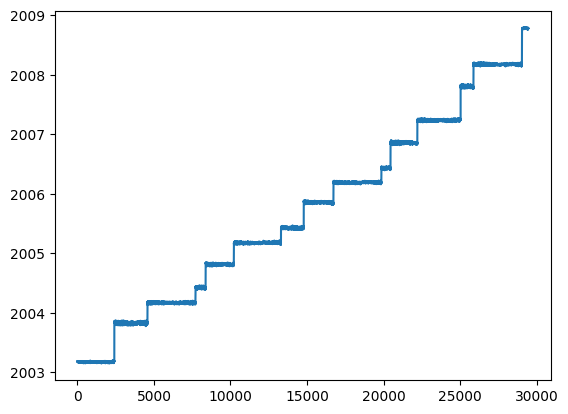

In [8]:
plt.plot(dt)

In [9]:
# Time to campaign time
cruises = np.unique(dico_ice['Cruise'])

In [10]:
cruises

array(['1', '2a', '2b', '2c', '3a', '3b', '3c', '3d', '3e', '3f', '3g',
       '3h', '3i', '3j', '3k'], dtype='<U12')

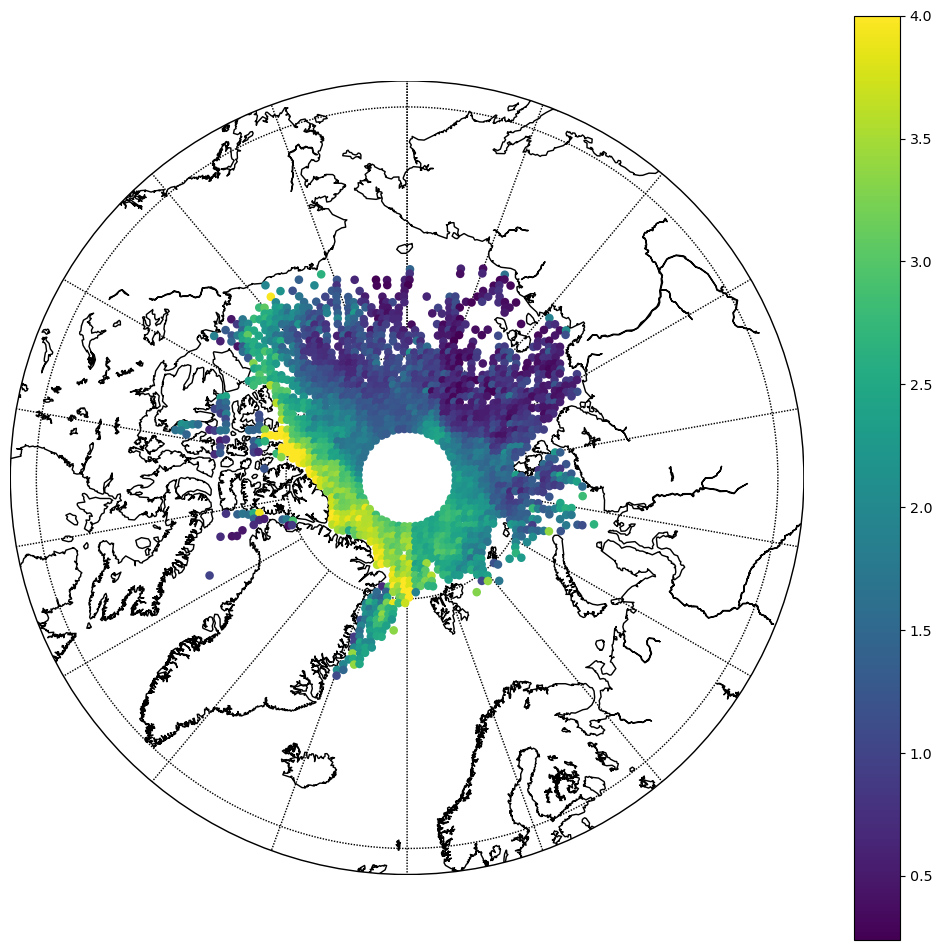

In [16]:
camp = '3d'  # '3b'
index = np.where((dico_ice['Cruise']==camp))

quickplot.basemap(dico_ice['Lon'][index], dico_ice['Lat'][index], var=dico_ice['Avg_thkns'][index], savefig=False, ofile=ofile, vmax=4, label='SIT (m)')


In [44]:
# time interval for a given campaign
# plt.plot(dt[np.where(dico_ice['Cruise']==camp)])

In [41]:
t_min = np.min(dt_min[np.where(dico_ice['Cruise']==camp)])
t_max = np.max(dt_max[np.where(dico_ice['Cruise']==camp)])

print(f'Campaign {camp}: from {t_min} to {t_max}')

Campaign 3d: from 2005-10-21 to 2005-11-24


In [42]:
from src.data_preparation import load_data

In [15]:
# -----------------------------------
#         Load TOPAZ 2000-2010
# -----------------------------------

# global prediction RF:  (as example)
filename = f'{rootdir}Leo/results/rf_221229-171734/ml/sit_ml_2000_2011.nc'
# Saved as: /scratch/project_465000269/edelleo1/Leo/results/rf_221229-171734/ml/sit_ml_2000_2011.nc
ml_model = 'RF'

In [43]:
filename = f'{rootdir}Leo/results/lstm_230201-112355/ml/sit_gLSTM_2000_2011.nc'
# Saved as: /scratch/project_465000269/edelleo1/Leo/results/rf_221229-171734/ml/sit_ml_2000_2011.nc
ml_model = 'LSTM'

In [44]:
sit, chrono = load_data.load_nc(filename, 'sit_ml', X_only=True)

# Cap negative value at 0 m (while keeping nan)
sit = (sit.where((0<sit), 0)).where(np.isfinite(sit))

In [45]:
sit;

In [46]:
import os
import netCDF4 as nc4
import xarray as xr

In [47]:
sit_na, _ = load_data.load_nc(filename, 'sit_na', X_only=True)

In [48]:
# -----------------------------------
#      compute baseline
# -----------------------------------
# from src.feature_extraction import baseline
from src.feature_extraction import mean_error

pca_dir = 'Leo/results/pca_i100-550_j300-629/'

basefile = os.path.join(rootdir, pca_dir, f"Baseline_monthly_error_2013_2019.nc")
nc = nc4.Dataset(basefile, mode='r')
bl_xe_mm = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['Xe_mm']
        

In [49]:
# apply to self.sit_na, chrono_a
sit_bl = mean_error.apply_mean_correction(chrono, sit_na, bl_xe_mm)

In [ ]:
# -------------------------------
#           Localisation
# -------------------------------


In [50]:
def get_tindex_period(chrono, d1, d2):
    '''Returns indexes in TOPAZ between 2 datetime objects
    
    Parameters:
    -----------
        chrono   :       chrono from TOPAZ4
        d1       :       datetime object, first date in date
        d2       :       datetime object, lastest date in date
    '''
    # identify index to plot
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    idx_min = np.where(chrono_dt==d1)[0]
    idx_max = np.where(chrono_dt==d2)[0]    
    
    return np.arange(idx_min, idx_max+1)

In [51]:
def get_closest_mean_std(lat, lon, tmin, tmax, sit_tp, chrono):
    '''
    Returns TOPAZ SIT (mean and std) for closest point in space and over time interval
    for one given (lat, lon) point (from ICESAT campaigns)
    
    Parameters:
    -----------
        lat           :    latitude of one given point
        lon           :    longitude of one given point
        tmin          :    datetime object, first date of one given point
        tmax          :    datetime object, last date of one given point
        sit_tp        :    xarray.DataArray, Sea Ice Thickness ML-corrected from TOPAZ4
        chrono        :    panda.DataFrame, dates associated to sit_tp
    
    '''

    # for oone given (lat,lon) point
    # get time index between Time min and Time max
    tloc = get_tindex_period(chrono, t_min, t_max)
    
    # localise the closest TOPAZ points for the (lat, lon) point
    # from https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(sit_tp.latitude-lat)
    abslon = np.abs(sit_tp.longitude-lon)
    c = np.maximum(abslon, abslat)
    closest = np.where(c == np.min(c))
    
    if closest[0].size > 1:  # rare case where one (lat,lon) point is at equal distance of 2 grid points
        # then we just pick the first one
        yloc = closest[0][0]
        xloc = closest[1][0]
    else:
        ([yloc], [xloc]) = closest
    
    point_ds = sit_tp.isel(time=tloc, x=xloc, y=yloc)
    
    # print(f'TOPAZ4 global corrected with RF, SIT: {point_ds.mean().data}')
    # print(f'ICESAT , SIT: {dico_ice["Avg_thkns"][index][pi]}')
    
    return np.array([point_ds.mean(), point_ds.std()])

    

In [52]:
tp_mean_std = np.zeros((len(index[0]),2))
tp_bl_mean_std = np.zeros((len(index[0]),2))  # baseline


for ni, idx_pt in enumerate(index[0]):
    tp_mean_std[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sit, chrono)
    tp_bl_mean_std[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sit_bl, chrono)    

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

In [53]:
# point returned as np.nan means that closest TOPAZ grid point is on land
idx_nan = np.unique(np.where(np.isnan(tp_mean_std))[0])
print(f'Lost points because on land in TOPAZ:  {idx_nan.size}')

Lost points because on land in TOPAZ:  6


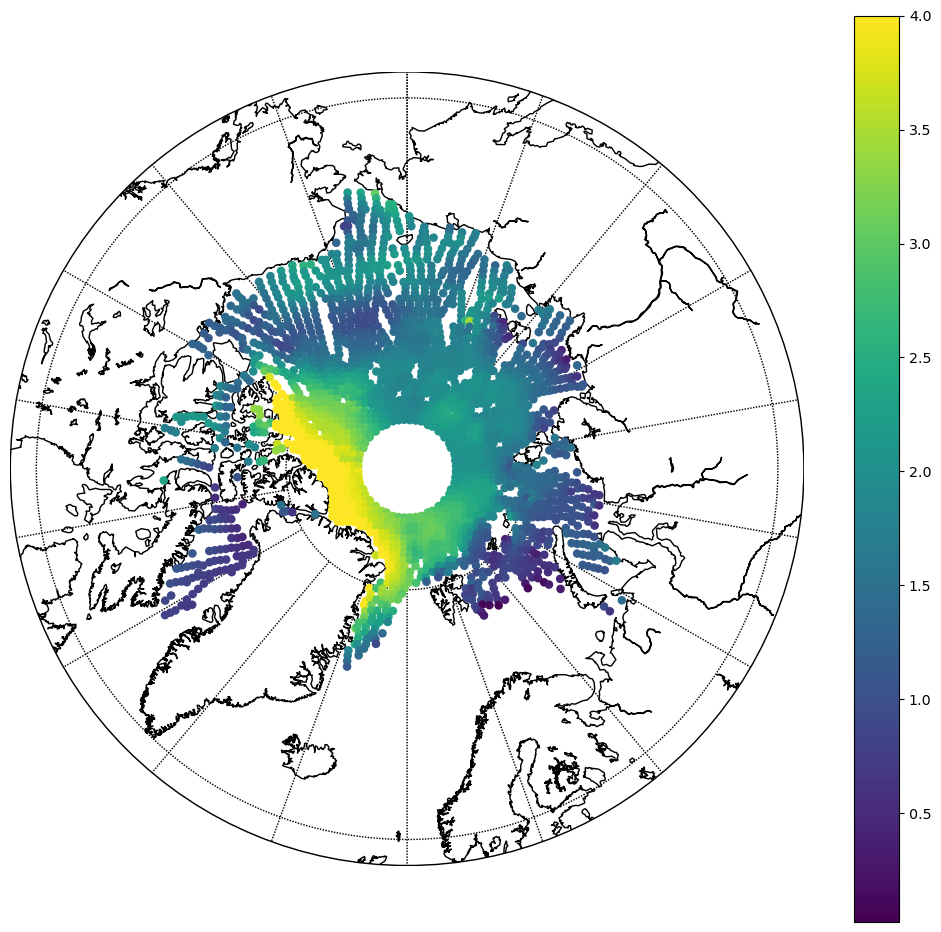

In [209]:
# quickplot.basemap(dico_ice['Lon'][index], dico_ice['Lat'][index], var=sit_tp[:,0], savefig=False, ofile=ofile, vmax=4, label='SIT (m)')

# Plots

In [54]:
from mpl_toolkits.basemap import Basemap

def double_basemap(lats, lons, sit_obs, sit_tp, suptitle='', odir='', ofile='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz
    
    '''
    
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)
    
    m = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[0])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0].set_title('ICESAT')
    
    
    m2 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
    axes[1].set_title('TOPAZ Baseline')  # LSTM')
    
    
    fig.colorbar(cs2, ax=axes, shrink=0.3, location="bottom", extend='max')
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()

In [55]:
def draw_violin_scatter(sit_obs, sit_tp, suptitle='', odir='', ofile='', savefig=False, showfig=True):
    '''
    '''
    
    fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)
    
    
    axes[0].violinplot(sit_obs, [0], showmeans=True)
    axes[0].violinplot(sit_tp[~np.isnan(sit_tp)], [1], showmeans=True)
    
    axes[0].set_xlabel('')
    axes[0].set_ylabel('SIT (m)')
    
    axes[0].set_xticks([0,1])
    axes[0].set_xticklabels(['ICESAT', 'TOPAZ LSTM'])

    
    axes[1].scatter(sit_obs, sit_tp)
    mini = np.floor(np.nanmin([sit_obs, sit_tp]))
    maxi = np.ceil(np.nanmax([sit_obs, sit_tp]))   
    axes[1].plot([mini, maxi], [mini, maxi], '--', c='grey')  # , zorder=-10)

    axes[1].set_xlabel('ICESAT')
    axes[1].set_ylabel('TOPAZ LSTM')
    axes[1].set_xlim(0, maxi)
    axes[1].set_ylim(0, maxi)
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24, rx=0)

    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()

    plt.close()
    
    

In [56]:
lons = dico_ice['Lon'][index]
lats = dico_ice['Lat'][index]
sit_obs = dico_ice['Avg_thkns'][index]
sit_tp = tp_mean_std[:,0]

sit_tp_bl = tp_bl_mean_std[:,0]

t_min = np.min(dt_min[np.where(dico_ice['Cruise']==camp)])
t_max = np.max(dt_max[np.where(dico_ice['Cruise']==camp)])
title = f'Campaign {camp}: from {t_min} to {t_max}'

In [57]:
odir = f'{rootdir}Leo/results/SIT_observations/'
ofile = f'ICESAT_TOPAZ{ml_model}_C{camp}_basemap.png'

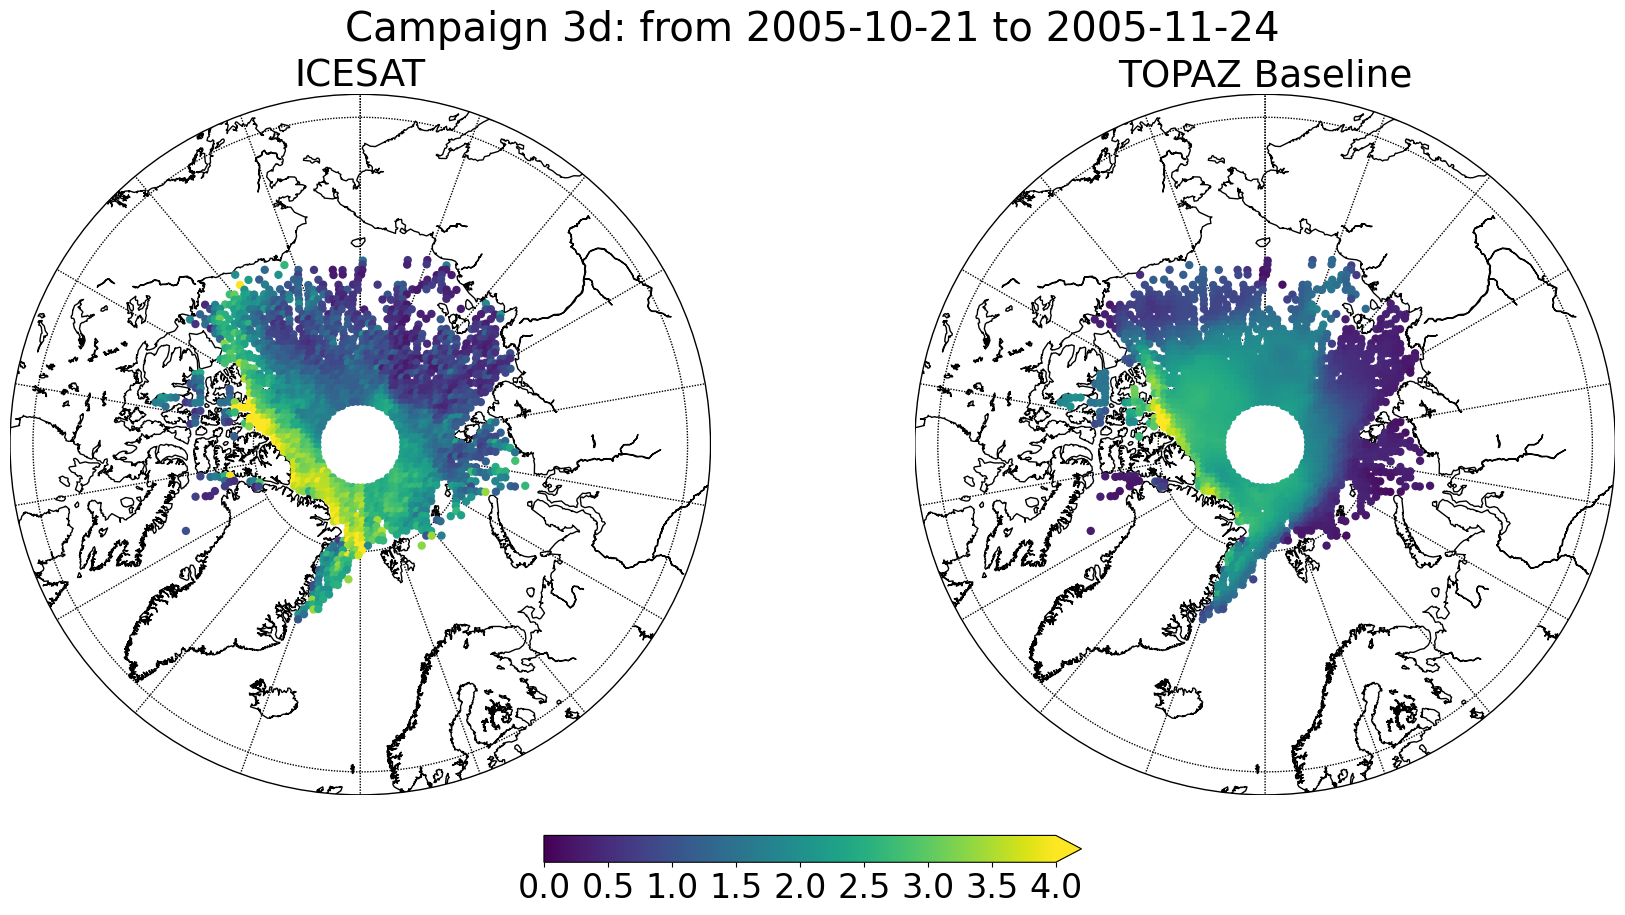

In [58]:
double_basemap(lats, lons, sit_obs, sit_tp, suptitle=title, vmin=0, vmax=4) # , odir=odir, ofile=ofile, savefig=True)

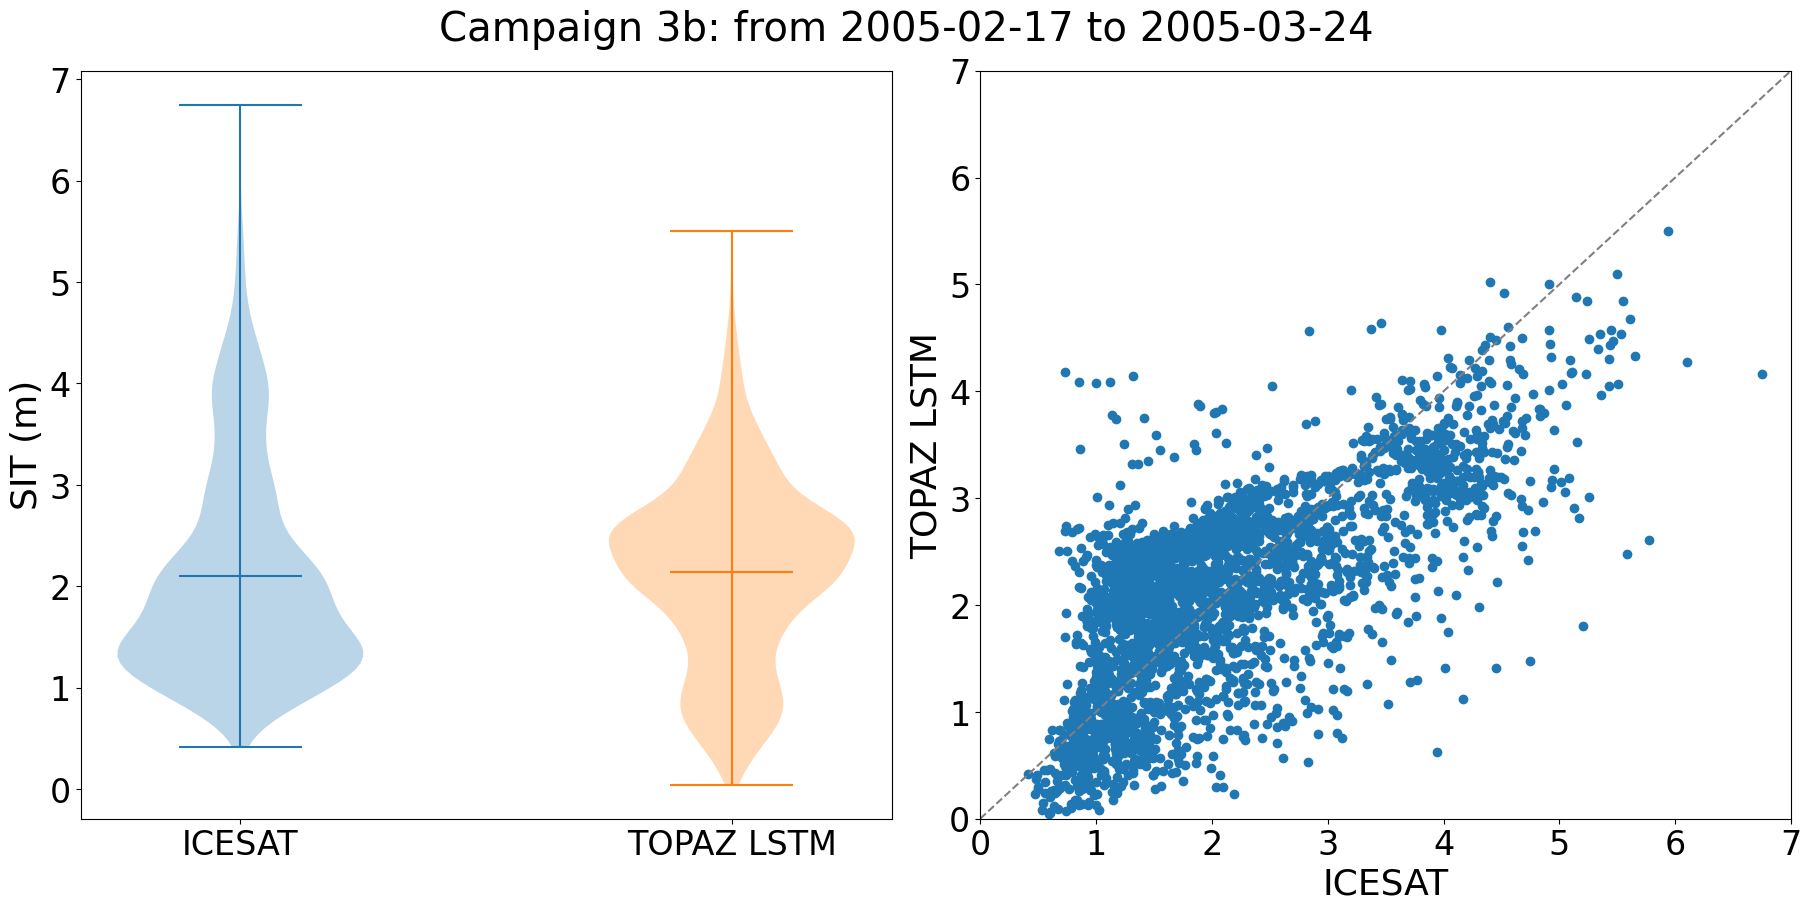

In [71]:
ofile = f'ICESAT_TOPAZ{ml_model}_C{camp}_violin_scatter.png'
draw_violin_scatter(sit_obs, sit_tp, suptitle=title) # , odir=odir, ofile=ofile, savefig=True)

In [ ]:
# plot baseline


In [33]:
odir = f'{rootdir}Leo/results/SIT_observations/'
ofile = f'ICESAT_TOPAZbaseline_C{camp}_basemap.png'

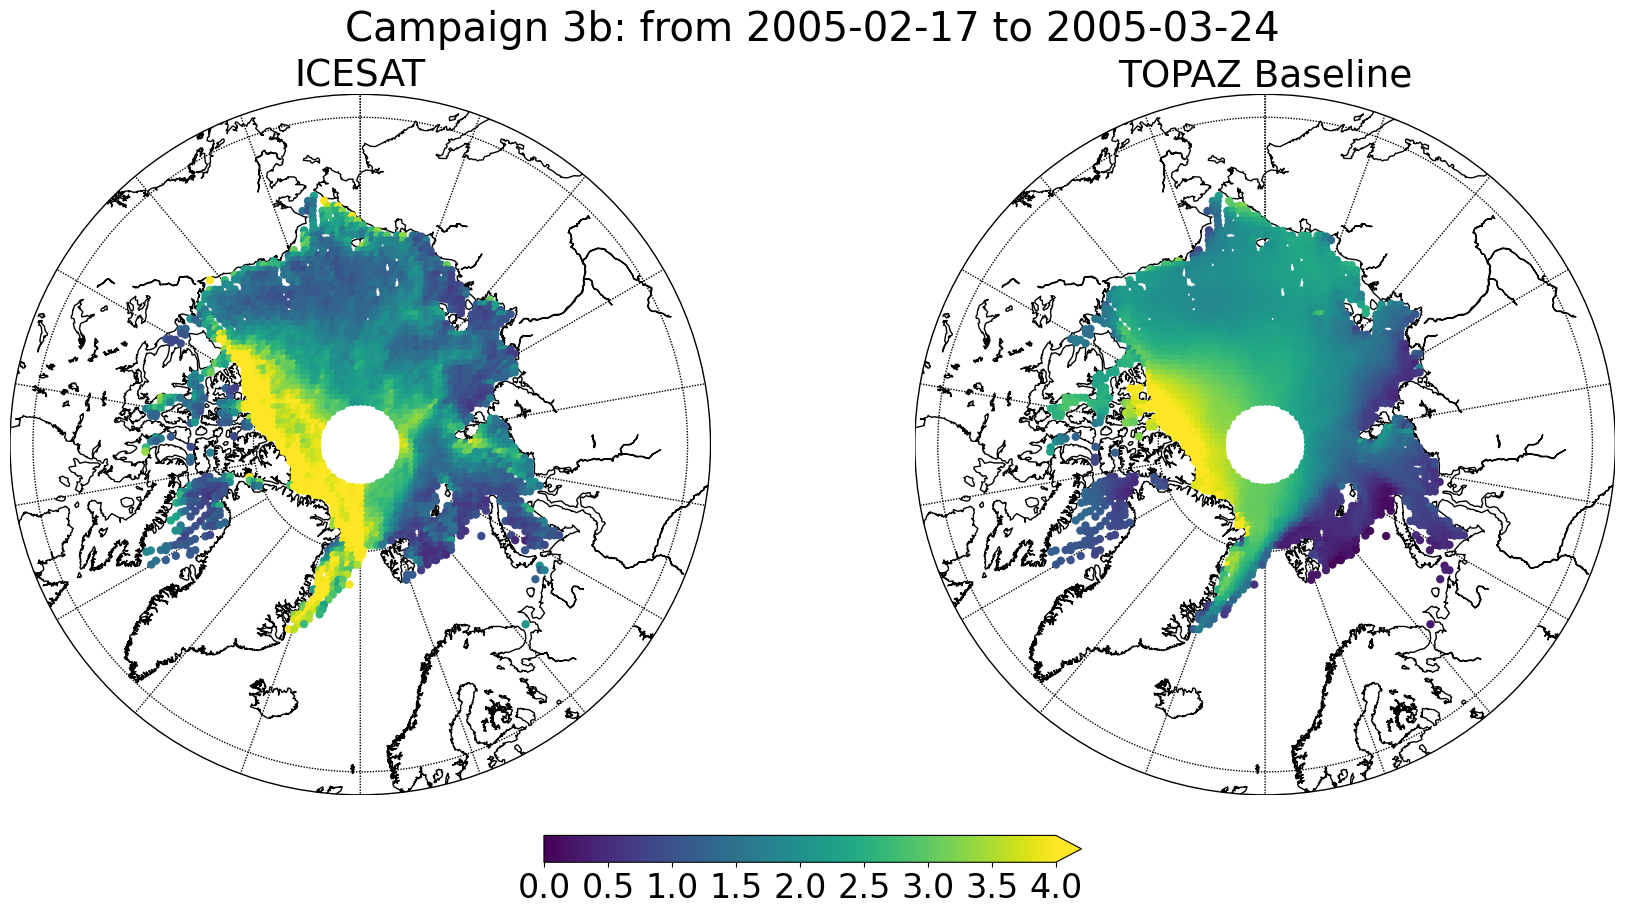

In [67]:
double_basemap(lats, lons, sit_obs, sit_tp_bl, suptitle=title, vmin=0, vmax=4) # , odir=odir, ofile=ofile, savefig=True)

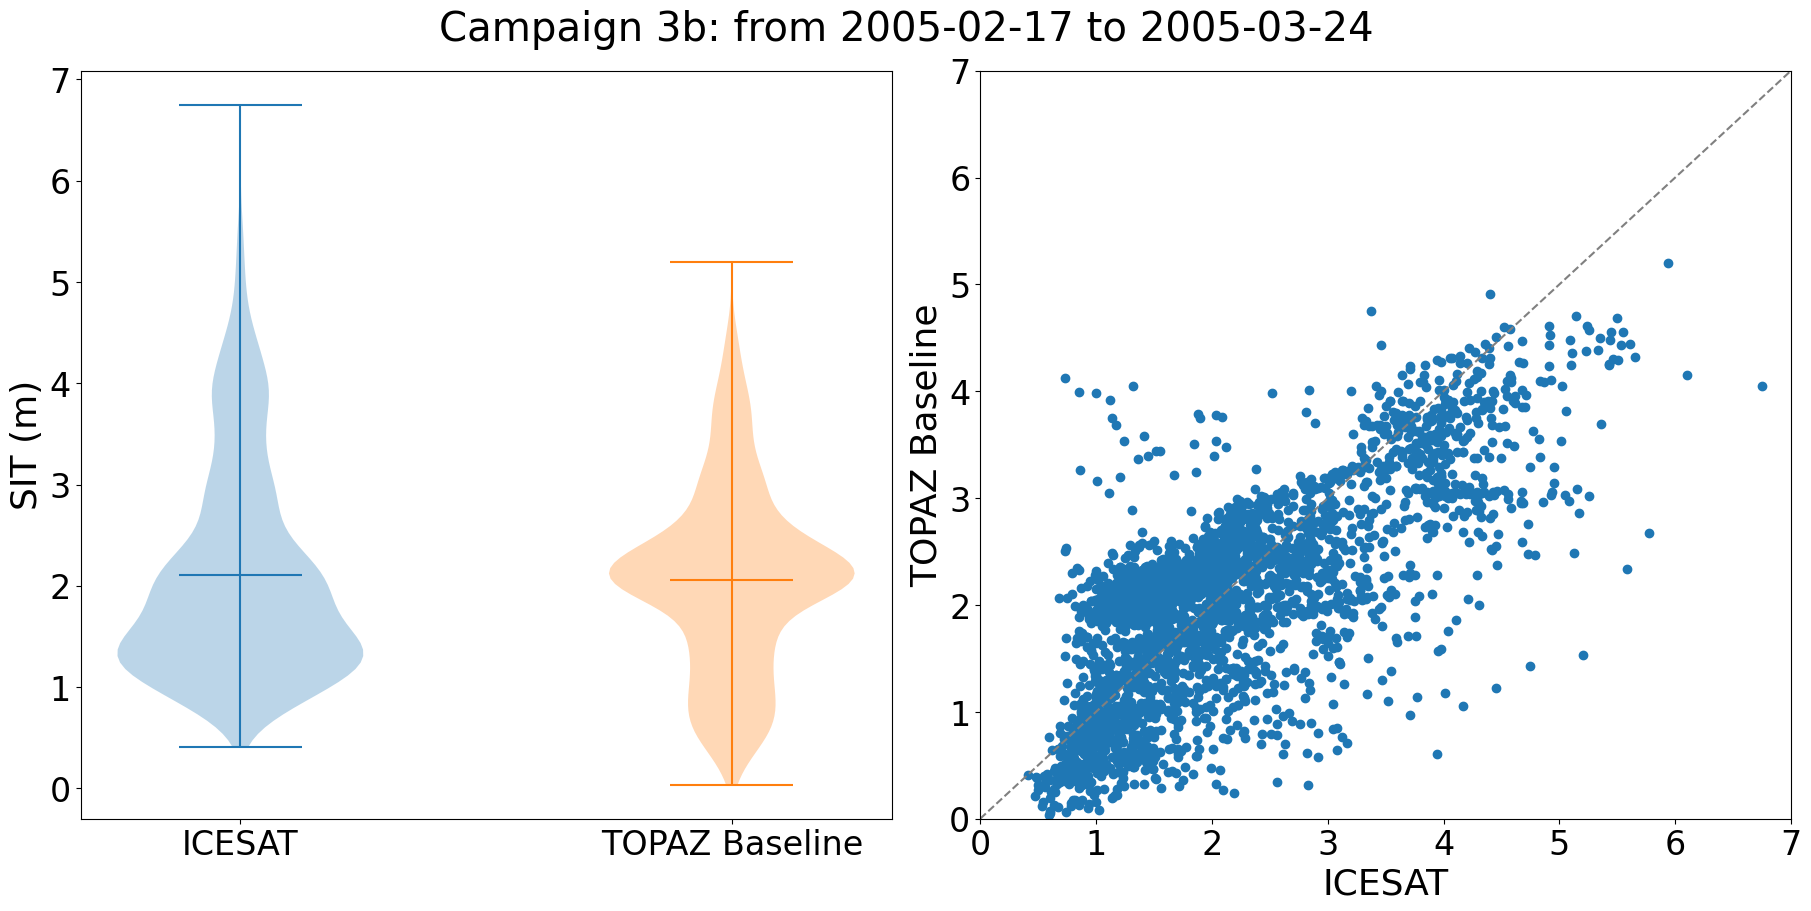

In [69]:
ofile = f'ICESAT_TOPAZbaselin_C{camp}_violin_scatter.png'
draw_violin_scatter(sit_obs, sit_tp_bl, suptitle=title) # , odir=odir, ofile=ofile, savefig=True)

--------------------------

# Useless functions

In [273]:
def scatter_obs(sit_obs, sit_tp, savefig=False, showfig=True):

    fig, ax = plt.subplots(figsize=(9,9), constrained_layout=True)

    ax.scatter(sit_obs, sit_tp)
    mini = np.floor(np.nanmin([sit_obs, sit_tp]))
    maxi = np.ceil(np.nanmax([sit_obs, sit_tp]))   
    ax.plot([mini, maxi], [mini, maxi], '--', c='grey')  # , zorder=-10)

    ax.set_xlabel('ICESAT')
    ax.set_ylabel('TOPAZ ML')
    ax.set_xlim(0, maxi)
    ax.set_ylim(0, maxi)
    
    if savefig:
        print('todo')

    if showfig:
        plt.show()

    plt.close()
    

In [271]:
def draw_violin(sit_obs, sit_tp, savefig=False, showfig=True):
    fig, ax = plt.subplots(figsize=(9,9), constrained_layout=True)
    
    plt.violinplot(sit_obs, [0], showmeans=True)
    plt.violinplot(sit_tp, [1], showmeans=True)
    
    ax.set_xlabel('')
    ax.set_ylabel('SIT (m)')
    
    ax.set_xticks([0,1])
    ax.set_xticklabels(['ICESAT', 'TOPAZ'])
    
    if savefig:
        print('todo')

    if showfig:
        plt.show()

    plt.close()

In [224]:
# plotting lost points
# quickplot.basemap(dico_ice['Lon'][index][idx_nan], dico_ice['Lat'][index][idx_nan], var=dico_ice['Avg_thkns'][index][idx_nan], savefig=False, ofile=ofile, vmax=4, label='SIT (m)')